# Static preprocessing implementations

Getting some sample data we can test the classes on

In [1]:
%cd ..

/data/mas322/amex-project


In [2]:
import yaml
import os
import importlib
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import sklearn

from src.lib import experimentation
from src.models import basic_grunet
import src.experiments.static_preprocessing_methods.experiment_setup as spm

with open(os.path.join("config.yaml")) as f:
    cfg = yaml.load(f, Loader=yaml.FullLoader)

# Note this should follow the interface of sklearn BaseEstimator using a fit, transform and fit_transform function
class IdentityTransform(sklearn.base.TransformerMixin, sklearn.base.BaseEstimator):
    def __init__(self):
        pass
    
    def fit(self, X, y = None):
        # https://docs.cupy.dev/en/stable/user_guide/interoperability.html#pytorch
        # consider using cupy if too slow with base numpy ^^
        return self
    
    def transform(self, X):
        return X

data_loader_kwargs = {
    'batch_size' : 1024,
    'shuffle' : True,
    'drop_last' : True,
}

fill_dict = {
    'nan' : -0.5,
    'pad_categorical' : -2,
    'pad_numeric' : -1.,
}

np.random.seed(42)
torch.manual_seed(42)

# load corrupted data
train_loader, val_loader = experimentation.load_numpy_data(
    os.path.join(cfg['dataset_directory'], "derived", "processed-splits"),
    val_idx=[0, 1],
    fill_dict=fill_dict,
    preprocess_obj=IdentityTransform(),
    corrupt_func=spm.undo_min_max_corrupt_func,
    **data_loader_kwargs)

for X, y in train_loader:
    break
X, y = X.numpy()[:, :, 11:], y.numpy()[11:]
print(f"X shape: {X.shape}")

# also load uncorrupted data for sanity checking
train_loader, val_loader = experimentation.load_numpy_data(
    os.path.join(cfg['dataset_directory'], "derived", "processed-splits"),
    val_idx=[0, 1],
    fill_dict=fill_dict,
    preprocess_obj=IdentityTransform(),
    corrupt_func=None,
    **data_loader_kwargs)
for X_uncorrupted, _ in train_loader:
    break
X_uncorrupted = X_uncorrupted.numpy()[:, :, 11:]

X shape: (1024, 13, 177)


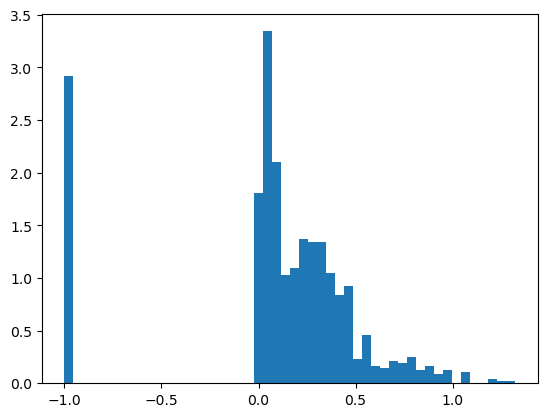

In [7]:
import matplotlib.pyplot as plt

plt.hist(X_uncorrupted[:, 1, 12], bins = 50, density=True)
plt.show()

## Standard scaling

In [16]:
torch.zeros((5,)).is_cuda

False

In [17]:
# TODO

## Decimal scaling

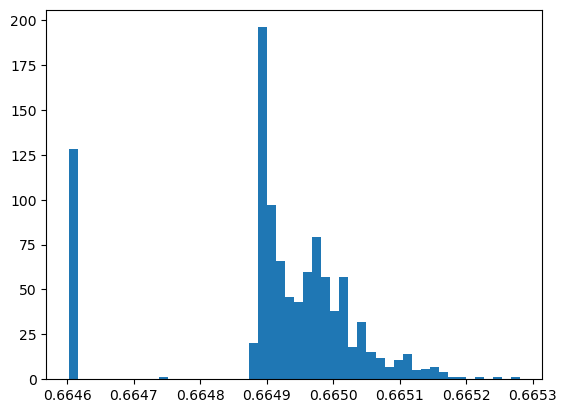

In [5]:
class DecimalScaling(sklearn.base.TransformerMixin, sklearn.base.BaseEstimator):
    def __init__(self, time_series_length=13):
        self.T = time_series_length
        pass
    
    def fit(self, X, y = None):
        # merge the dimensions and time axis
        X = X.reshape((X.shape[0], -1))
        max_vals = np.max(np.abs(X), axis=0)
        # the exponent (base 10) that each feature should be scaled with
        q = np.array(np.log10(max_vals) + 1, dtype=np.int16)
        self.scale_factor = 1 / np.power(10., q, dtype=np.float32)
        return self
    
    def transform(self, X):
        X = X.reshape((X.shape[0], -1))
        # scale all the features
        X = X * self.scale_factor
        return X.reshape((X.shape[0], self.T, -1))

ds = DecimalScaling()
X_new = ds.fit_transform(X, y)
plt.hist(X_new[:, 1, 12], bins=50)
plt.show()

## Min-Max scaling

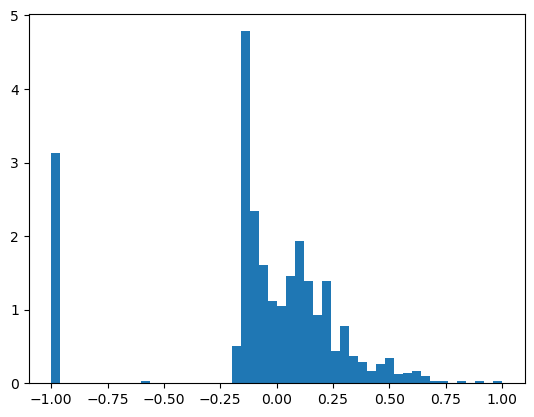

In [28]:
from sklearn import preprocessing

class MinMaxTimeSeries(sklearn.base.TransformerMixin, sklearn.base.BaseEstimator):
    def __init__(self, a=0, b=1, time_series_length=13):
        self.T = time_series_length
        self.min_max_scaler = preprocessing.MinMaxScaler(feature_range=(a, b))
        pass
    
    def fit(self, X, y = None):
        # merge the dimensions and time axis
        X = X.reshape((X.shape[0], -1))
        self.min_max_scaler.fit(X, y)
        return self
    
    def transform(self, X):
        X = X.reshape((X.shape[0], -1))
        # scale all the features
        X = self.min_max_scaler.transform(X)
        return X.reshape((X.shape[0], self.T, -1))

min_max = MinMaxTimeSeries(-1, 1)
X_new = min_max.fit_transform(X, y)
plt.hist(X_new[:, 1, 12], bins=50, density=True)
plt.show()

## Analysing results

In [ ]:
no_preprocess = np.load(os.path.join(cfg['experiment_directory'], 'no-preprocess-history.npy'), allow_pickle=True).item()
no_preprocess.keys()

dict_keys(['train_loss', 'val_loss', 'train_amex_metric', 'val_amex_metric', 'train_loss_mean', 'train_loss_sd', 'val_loss_mean', 'val_loss_sd', 'train_amex_metric_mean', 'train_amex_metric_sd', 'val_amex_metric_mean', 'val_amex_metric_sd', 'num_epochs'])

In [4]:
def get_average(history, key):
    vals = []
    epoch = 0
    while True:
        avg_val = 0.
        num_vals = 0
        for i in range(5):
            if len(history[key][i]) > epoch:
                num_vals += 1
                avg_val += history[key][i][epoch]
        if num_vals == 0:
            break
        vals.append(avg_val / num_vals)
        epoch += 1
    return vals

def plot_cv(history, suffix, ax, **kwargs):
    train_mean = get_average(history, f"train_{suffix}")
    val_mean = get_average(history, f"val_{suffix}")
    # epoch = 0
    # while True:
    #     avg_train_val = 0.
    #     avg_val_val = 0.
    #     num_vals = 0
    #     for i in range(5):
    #         if len(history[f"train_{suffix}"][i]) > epoch:
    #             num_vals += 1
    #             avg_train_val += history[f"train_{suffix}"][i][epoch]
    #             avg_val_val += history[f"val_{suffix}"][i][epoch]
    #     if num_vals == 0:
    #         break
    #     train_mean.append(avg_train_val / num_vals)
    #     val_mean.append(avg_val_val / num_vals)
    #     epoch += 1
    
    for i in range(5):
        ax.plot(history[f"train_{suffix}"][i], alpha = 0.5,
                label = "Train" if i == 0 else None,
                color = 'tab:blue',
                linestyle = 'dashed', **kwargs)
        ax.plot(history[f"val_{suffix}"][i], alpha = 0.5,
                label = "Val" if i == 0 else None,
                color = 'tab:orange',
                linestyle = 'dashed', **kwargs)
        # add red dot if was terminates
        if len(history[f"train_{suffix}"][i]) < len(train_mean):
            ax.plot(len(history[f"train_{suffix}"][i]) - 1, history[f"train_{suffix}"][i][-1], color='red', marker='o', alpha=0.3)
            ax.plot(len(history[f"val_{suffix}"][i]) - 1, history[f"val_{suffix}"][i][-1], color='red', marker='o', alpha=0.3)
    
    ax.plot(train_mean, label="Train (CV mean)", **kwargs)
    ax.plot(val_mean, label="Val (CV mean)", **kwargs)
    ax.set_xlabel("Epoch")
    ax.set_ylabel(suffix)
    ax.legend()

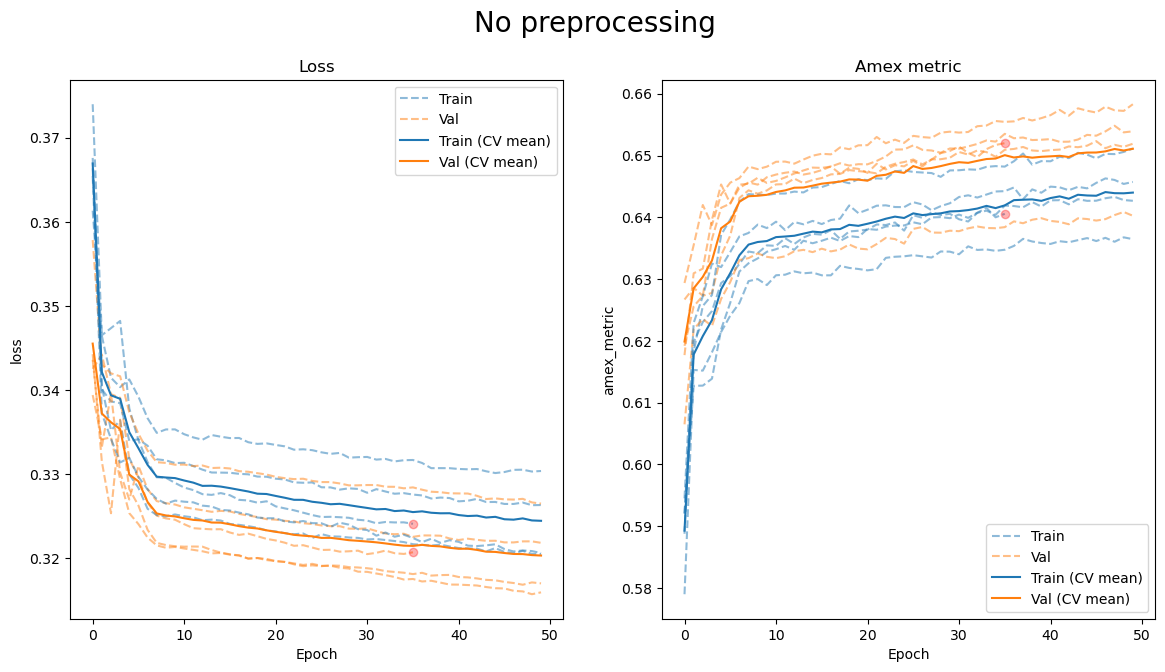

In [104]:
no_preprocess = np.load(os.path.join(cfg['experiment_directory'], 'no-preprocess-history-50-epochs.npy'), allow_pickle=True).item()
fig, axs = plt.subplots(ncols=2, figsize=(14, 7))
fig.suptitle("No preprocessing", fontsize=20)
plot_cv(no_preprocess, "loss", axs[0])
axs[0].set_title("Loss")
plot_cv(no_preprocess, "amex_metric", axs[1])
axs[1].set_title("Amex metric")
plt.show()

[15, 14, 16, 16, 10]


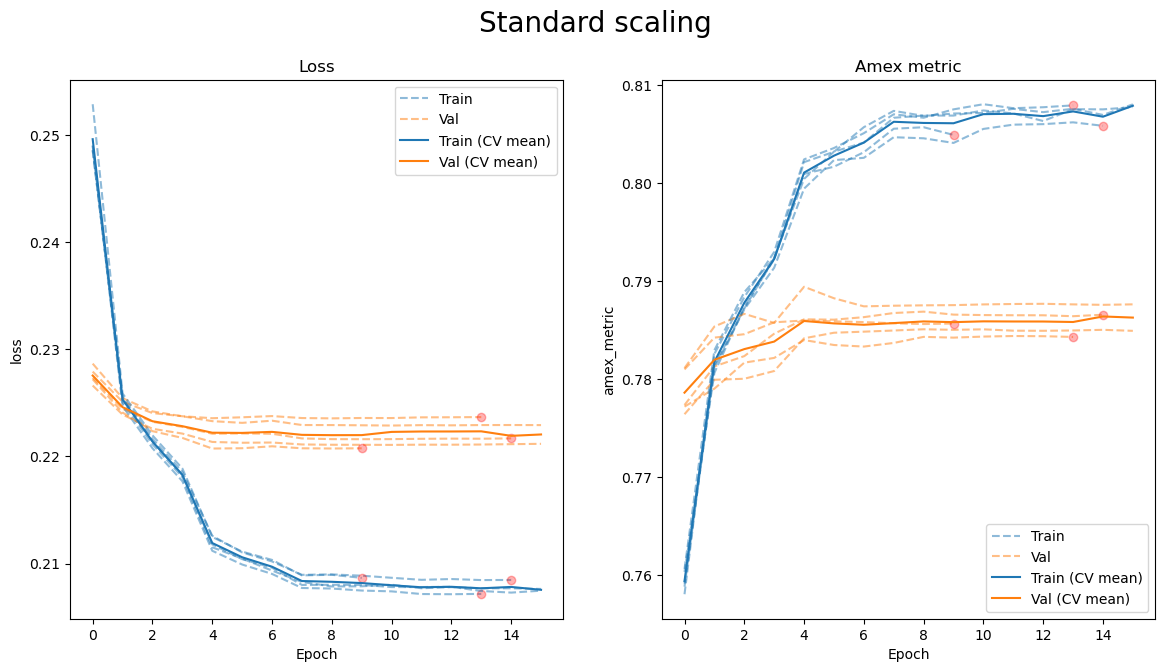

In [105]:
standard_scaling = np.load(os.path.join(cfg['experiment_directory'], 'standard-scaling-history-50-epochs.npy'), allow_pickle=True).item()
print(standard_scaling['num_epochs'])
fig, axs = plt.subplots(ncols=2, figsize=(14, 7))
plot_cv(standard_scaling, "loss", axs[0])
axs[0].set_title("Loss")
plot_cv(standard_scaling, "amex_metric", axs[1])
axs[1].set_title("Amex metric")
fig.suptitle("Standard scaling", fontsize=20)
plt.show()

In [92]:
!ls /home/silo1/mas322/experiment-results

min-max-scaling-history-50-epochs.npy
min-max-scaling-history.npy
no-preprocess-history-50-epochs.npy
no-preprocess-history.npy
standard-scaling-history-50-epochs.npy
standard-scaling-history-no-corrupt.npy
standard-scaling-history.npy
tanh-standard-scaling-history-50-epochs.npy


[24, 21, 37, 50, 41]


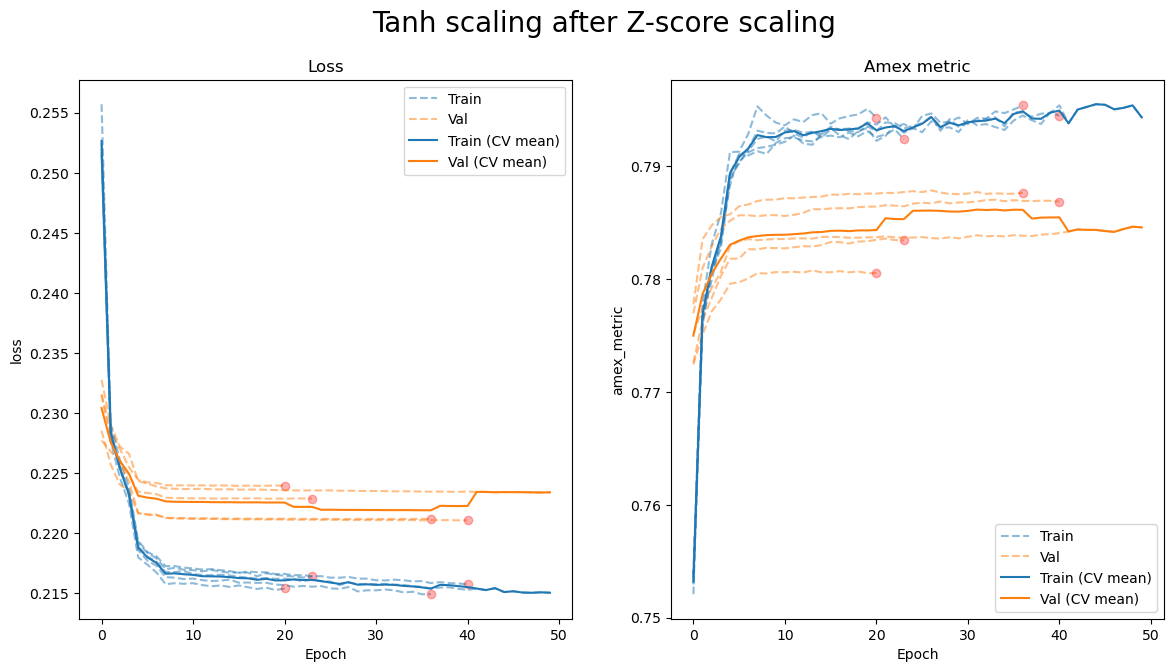

In [106]:
tanh_scaling = np.load(os.path.join(cfg['experiment_directory'], 'tanh-standard-scaling-history-50-epochs.npy'), allow_pickle=True).item()
print(tanh_scaling['num_epochs'])
fig, axs = plt.subplots(ncols=2, figsize=(14, 7))
plot_cv(tanh_scaling, "loss", axs[0])
axs[0].set_title("Loss")
plot_cv(tanh_scaling, "amex_metric", axs[1])
axs[1].set_title("Amex metric")
fig.suptitle("Tanh scaling after Z-score scaling", fontsize=20)
plt.show()

[50, 50, 50, 50, 50]


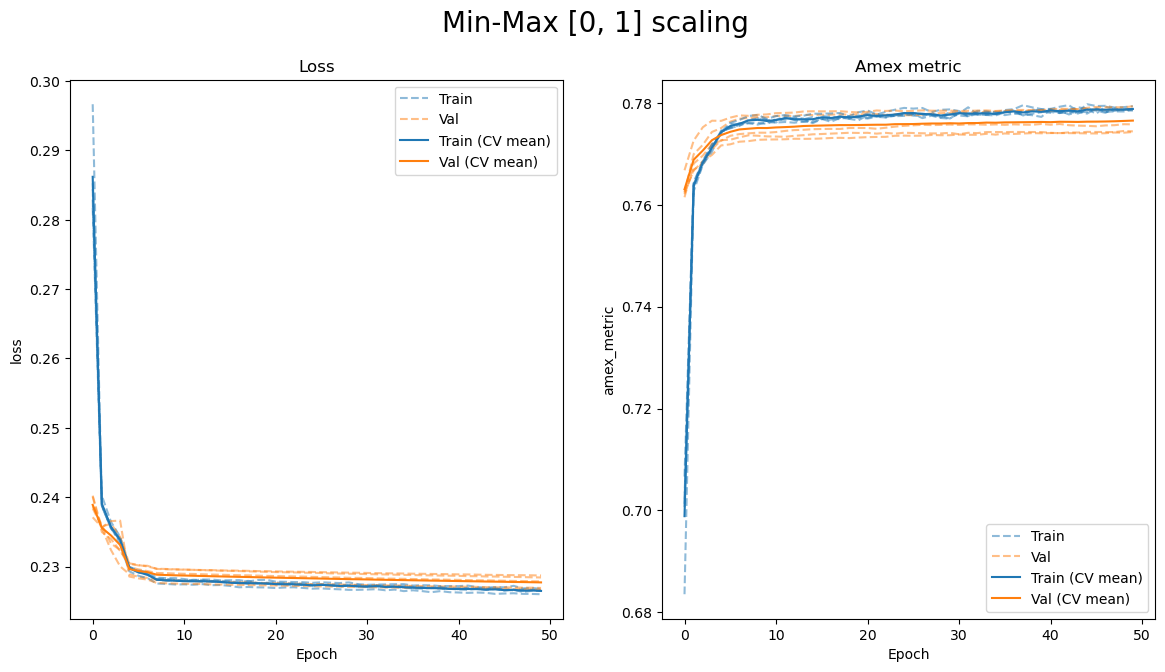

In [97]:
min_max = np.load(os.path.join(cfg['experiment_directory'], 'min-max-scaling-history-50-epochs.npy'), allow_pickle=True).item()
print(min_max['num_epochs'])
fig, axs = plt.subplots(ncols=2, figsize=(14, 7))
plot_cv(min_max, "loss", axs[0])
axs[0].set_title("Loss")
plot_cv(min_max, "amex_metric", axs[1])
axs[1].set_title("Amex metric")
fig.suptitle("Min-Max [0, 1] scaling", fontsize=20)
plt.show()

Plotting all the different preprocessing methods

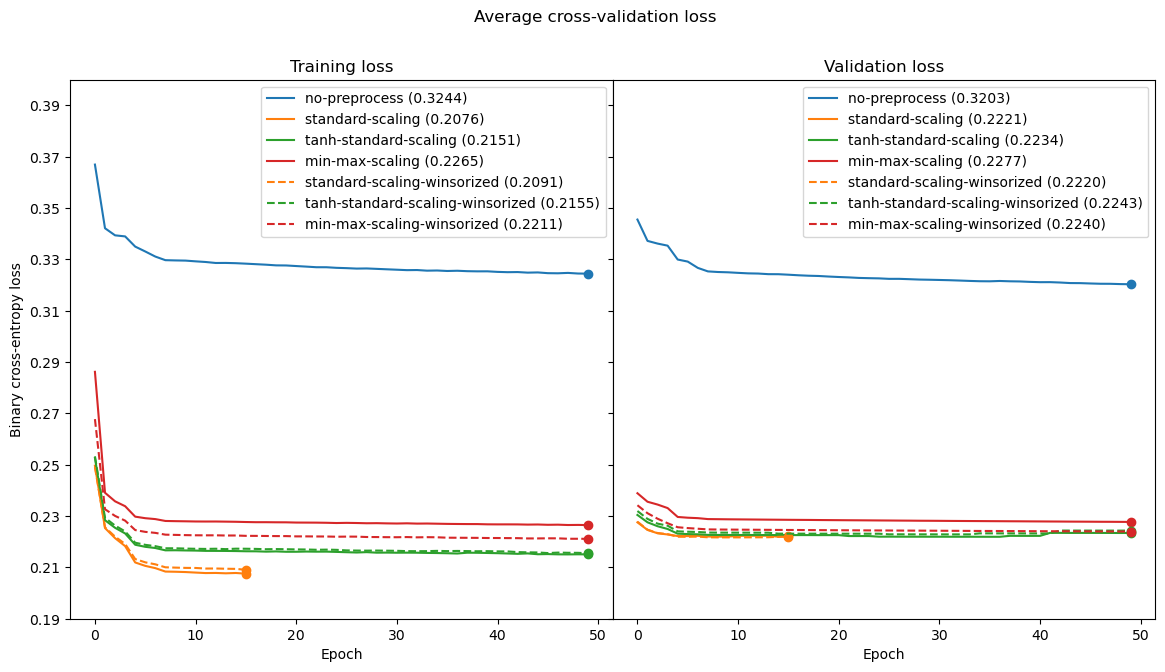

In [5]:
import matplotlib.pyplot as plt
methods = ['no-preprocess', 'standard-scaling', 'tanh-standard-scaling', 'min-max-scaling', 'standard-scaling-winsorized', 'tanh-standard-scaling-winsorized', 'min-max-scaling-winsorized']

fig, axs = plt.subplots(ncols = 2, figsize=(14, 7), sharey=True)
fig.subplots_adjust(wspace=0)

for m, c in zip(methods, ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:orange', 'tab:green', 'tab:red']):
    history = np.load(os.path.join(cfg['experiment_directory'], f"{m}-history-50-epochs.npy"), allow_pickle=True).item()
    train_cv_avgs = get_average(history, "train_loss")
    val_cv_avgs = get_average(history, "val_loss")
    if 'winsorized' in m:
        linestyle = '--'
    else:
        linestyle = '-'
    axs[0].plot(train_cv_avgs, label = f"{m} ({train_cv_avgs[-1]:.4f})", color=c, linestyle=linestyle)
    axs[0].plot(len(train_cv_avgs) - 1, train_cv_avgs[-1], marker='o', color=c)
    axs[0].set_yticks(np.arange(0.19, 0.40, 0.02))
    axs[0].set_ylim([0.19, 0.40])
    axs[1].set_yticks(np.arange(0.19, 0.40, 0.02))
    axs[1].set_ylim([0.19, 0.40])
    axs[1].plot(val_cv_avgs, label = f"{m} ({val_cv_avgs[-1]:.4f})", color=c, linestyle=linestyle)
    axs[1].plot(len(val_cv_avgs) - 1, val_cv_avgs[-1], marker='o', color=c)
axs[0].legend()
axs[0].set_xlabel("Epoch")
axs[1].set_xlabel("Epoch")
axs[0].set_ylabel("Binary cross-entropy loss")
axs[0].set_title("Training loss")
axs[1].set_title("Validation loss")
axs[1].legend()
fig.suptitle("Average cross-validation loss")
plt.show()

Below cell used to producde the plot for the **poster presentation**.

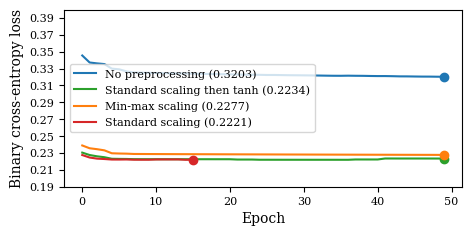

In [55]:
import matplotlib.pyplot as plt
methods = ['no-preprocess', 'tanh-standard-scaling', 'min-max-scaling', 'standard-scaling'] #, 'standard-scaling-winsorized', 'tanh-standard-scaling-winsorized', 'min-max-scaling-winsorized']
tex_fonts = {
    "text.usetex": False,
    "font.family": "serif",
    "axes.labelsize": 10,
    "font.size": 12,
    "legend.fontsize": 8,
    "legend.title_fontsize": 10,
    "xtick.labelsize": 8,  # 8 at full scale
    "ytick.labelsize": 8
}
plt.rcParams.update(tex_fonts)

fig, ax = plt.subplots(figsize=(300 * 1/0.8 / 73, 280 * 3/4 * 1/0.8 / 73 * 0.64))
fig.subplots_adjust(wspace=0)

for m, c, lab in zip(methods, ['tab:blue', 'tab:green', 'tab:orange', 'tab:red'], ['No preprocessing', 'Standard scaling then tanh', 'Min-max scaling', 'Standard scaling']):
    history = np.load(os.path.join(cfg['experiment_directory'], f"{m}-history-50-epochs.npy"), allow_pickle=True).item()
    train_cv_avgs = get_average(history, "train_loss")
    val_cv_avgs = get_average(history, "val_loss")
    ax.set_yticks(np.arange(0.19, 0.40, 0.02))
    ax.set_ylim([0.19, 0.40])
    ax.plot(val_cv_avgs, label = f"{lab} ({val_cv_avgs[-1]:.4f})", color=c, linestyle=linestyle)
    ax.plot(len(val_cv_avgs) - 1, val_cv_avgs[-1], marker='o', color=c, markersize=6)
ax.legend()
ax.set_xlabel("Epoch")
ax.set_ylabel("Binary cross-entropy loss")
# ax.set_title("Validation loss")
# axs[1].set_title("Validation loss")
# axs[1].legend()
# fig.suptitle("Average cross-validation loss")
# plt.show()
fig.savefig("/home/mas322/amex-project/reports/poster/Figures/poster-val-loss.pdf", bbox_inches='tight')

In [49]:
list(zip([1, 2], [3, 4], [5, 6]))

[(1, 3, 5), (2, 4, 6)]

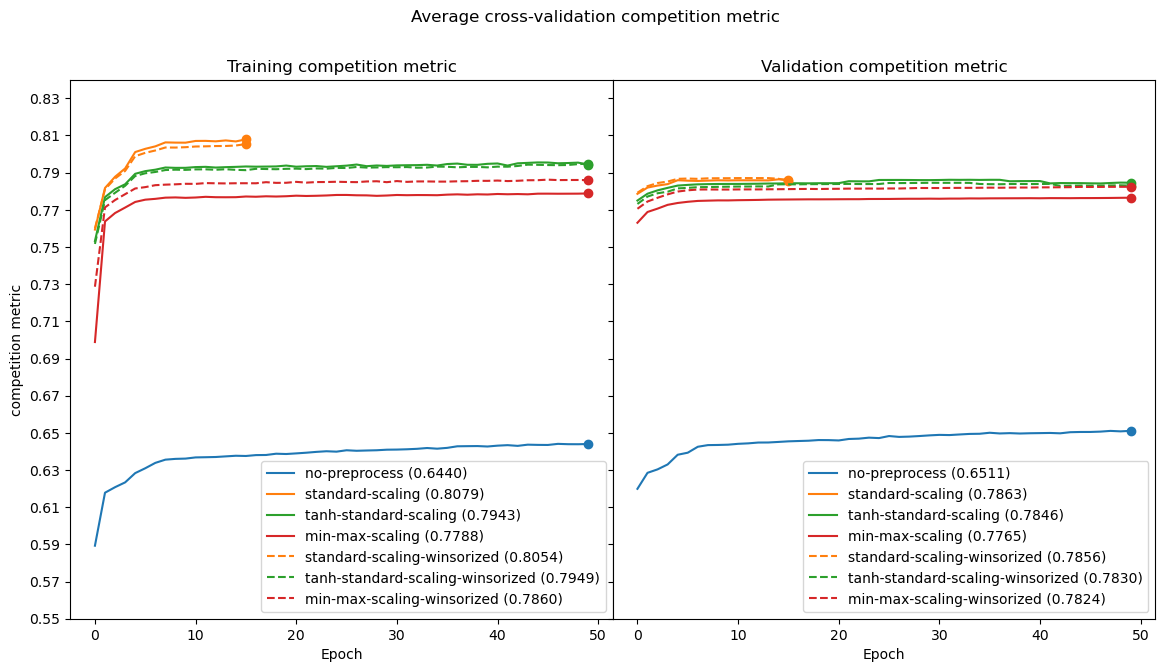

In [83]:
methods = ['no-preprocess', 'standard-scaling', 'tanh-standard-scaling', 'min-max-scaling', 'standard-scaling-winsorized', 'tanh-standard-scaling-winsorized', 'min-max-scaling-winsorized']

fig, axs = plt.subplots(ncols = 2, figsize=(14, 7), sharey=True)
fig.subplots_adjust(wspace=0)

for m, c in zip(methods, ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:orange', 'tab:green', 'tab:red']):
    history = np.load(os.path.join(cfg['experiment_directory'], f"{m}-history-50-epochs.npy"), allow_pickle=True).item()
    train_cv_avgs = get_average(history, "train_amex_metric")
    val_cv_avgs = get_average(history, "val_amex_metric")
    if 'winsorized' in m:
        linestyle = '--'
    else:
        linestyle = '-'
    axs[0].plot(train_cv_avgs, label = f"{m} ({train_cv_avgs[-1]:.4f})", color=c, linestyle=linestyle)
    axs[0].plot(len(train_cv_avgs) - 1, train_cv_avgs[-1], marker='o', color=c)
    axs[0].set_yticks(np.arange(0.55, 0.84, 0.02))
    axs[0].set_ylim([0.55, 0.85])
    axs[1].set_yticks(np.arange(0.55, 0.84, 0.02))
    axs[1].set_ylim([0.55, 0.84])
    axs[1].plot(val_cv_avgs, label = f"{m} ({val_cv_avgs[-1]:.4f})", color=c, linestyle=linestyle)
    axs[1].plot(len(val_cv_avgs) - 1, val_cv_avgs[-1], marker='o', color=c)
axs[0].legend()
axs[0].set_xlabel("Epoch")
axs[1].set_xlabel("Epoch")
axs[0].set_ylabel("competition metric")
axs[0].set_title("Training competition metric")
axs[1].set_title("Validation competition metric")
axs[1].legend()
fig.suptitle("Average cross-validation competition metric")
plt.show()

## Winsorization

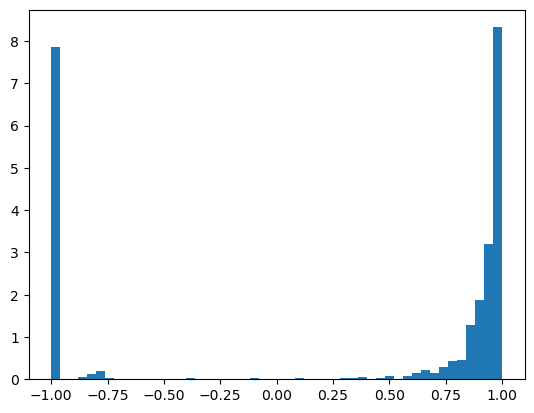

In [66]:
class WinsorizeDecorator(sklearn.base.TransformerMixin, sklearn.base.BaseEstimator):
    """
    Before fitting provided transformer winsorizes the data to be within
    the [alpha/2, 1-alpha/2] quantiles of the fitted data.
    """
    def __init__(self, TransformerClass, alpha=0.05, time_series_length=13, **kwargs):
        self.transformer = TransformerClass(**kwargs)
        self.T = time_series_length
        self.alpha = alpha
    
    def fit(self, X, y = None):
        # merge the dimensions and time axis
        X = X.reshape((X.shape[0], -1))
        # save the quantiles for each of the T * D variables
        self.lower = np.quantile(X.reshape((X.shape[0], -1)), q=self.alpha/2, axis=0)
        self.upper = np.quantile(X.reshape((X.shape[0], -1)), q=1-self.alpha/2, axis=0)
        # transform the data
        X = np.clip(X, self.lower, self.upper)
        # then fit the provided transformer on this winsorized data
        self.transformer = self.transformer.fit(X.reshape((X.shape[0], self.T, -1)), y)
        return self
    
    def transform(self, X):
        X = X.reshape((X.shape[0], -1))
        # clip all the features based on the learned percentiles
        X = np.clip(X, self.lower, self.upper)
        # apply the provided transformer
        return self.transformer.transform(X.reshape((X.shape[0], self.T, -1)))
    
min_max = MinMaxTimeSeries(-1, 1)
winsor_min_max = WinsorizeDecorator(MinMaxTimeSeries, alpha=0.4, a=-1, b=1)
X_new = winsor_min_max.fit_transform(X, y)
plt.hist(X_new[:, 2, 123], bins=50, density=True)
plt.show()

In [27]:
lower = np.quantile(X.reshape((X.shape[0], -1)), q=0.025, axis=0)
upper = np.quantile(X.reshape((X.shape[0], -1)), q=0.975, axis=0)
np.clip(X.reshape((X.shape[0], -1)), lower, upper)[:,2]

array([4639.88671875, 4639.88427734, 4639.88183594, ..., 4639.21044922,
       4639.88964844, 4639.8828125 ])

In [15]:
X.shape

(1024, 13, 177)